In [ ]:
import pandas as pd
import nltk
import re
import string
#import numpy as np

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import metrics

%matplotlib notebook

In [ ]:
# nltk libraries
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import PorterStemmer

stopwords = stopwords.words('english')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/data-science

Mounted at /gdrive
/gdrive/MyDrive/data-science


In [ ]:
import bz2 #unzip and load

In [ ]:
train_file = bz2.BZ2File('train.ft.txt.bz2')
test_file = bz2.BZ2File('test.ft.txt.bz2')

In [ ]:
# 2 minutes
# 3600000 train lines, 400000 test lines
train_lines = train_file.readlines()
test_lines = test_file.readlines()

In [ ]:
print('Train line: {}'.format(train_lines[11]))

Train line: b'__label__2 Great book: This was a great book,I just could not put it down,and could not read it fast enough. Boy what a book the twist and turns in this just keeps you guessing and wanting to know what is going to happen next. This book makes you fall in love and can heat you up,it can also make you so angery. this book can make you go throu several of your emotions. This is a quick read romance. It is something that you will want to end your day off with if you read at night.\n'


In [ ]:
train_lines = [x.decode('utf-8') for x in train_lines]
test_lines = [x.decode('utf-8') for x in test_lines]

In [ ]:
train_lines[11].split(' ',1)

['__label__2',
 'Great book: This was a great book,I just could not put it down,and could not read it fast enough. Boy what a book the twist and turns in this just keeps you guessing and wanting to know what is going to happen next. This book makes you fall in love and can heat you up,it can also make you so angery. this book can make you go throu several of your emotions. This is a quick read romance. It is something that you will want to end your day off with if you read at night.\n']

In [ ]:
# text line divided by only the 1st blank space (split(' ',1)) => get 2 lines(1 for label and 1 sentence)
# then take only the sentence without the enter(\n) of last ([1][:-1])
# finally transform to lowercase
tl = train_lines[11].split(' ',1)[1][:-1].lower()
print(tl)
#print(re.sub('\d','0',tl))

great book: this was a great book,i just could not put it down,and could not read it fast enough. boy what a book the twist and turns in this just keeps you guessing and wanting to know what is going to happen next. this book makes you fall in love and can heat you up,it can also make you so angery. this book can make you go throu several of your emotions. this is a quick read romance. it is something that you will want to end your day off with if you read at night.


In [ ]:
# shuffle the review lines, then get a partial dataset from them
from sklearn.utils import shuffle
train_lines = shuffle(train_lines)
test_lines = shuffle(test_lines)

We take a partial dataset to improve times...

In [ ]:
train_part = train_lines[:10000]
test_part = test_lines[:2000]
# Put all together
amz_rev_part = train_part + test_part

In [ ]:
# Get label text and return 0 (__label__1=bad review) and 1 (__label__1=good_review)
def reviewToY(review):
    # return [1,0] if review.split(' ')[0] == '__label__1' else [0,1]
    return 0 if review.split(' ')[0] == '__label__1' else 1

In [ ]:
# Get review string feature
# delete the last char (\n) and transform to lower
def reviewToX(review):
    review = review.split(' ', 1)[1][:-1].lower()
    return review

In [ ]:
def splitReviewsLabels(lines):
    from tqdm import tqdm
    
    reviews = []
    labels = []
    for review in tqdm(lines):
        rev = reviewToX(review)
        label = reviewToY(review)
        # only get the first 512 chars for review
        reviews.append(rev[:512])
        labels.append(label)
    return reviews, labels

In [ ]:
# Load review_train, y_train and review_test, y_test from the partial datasets
X_amz_rev_part, y_amz_rev_part = splitReviewsLabels(amz_rev_part)

100%|██████████| 12000/12000 [00:00<00:00, 145697.11it/s]


In [ ]:
print('Label: {} - Review: {}'.format(y_amz_rev_part[8], X_amz_rev_part[8]))

Label: 1 - Review: all great except the smell: i like the natural ingredients. it looks like a natural product in the hands, without chemical textures or synthetic appearance. i like the way it feels on my skin, similar to the sensation of rubbing a mixture of delicate oils and fruit on my face. it cleanses thoroughly removing makeup and sunblock lotion. it doesn't strip my skin dry and instead leaves a nice moisture after wash. the only drawback is the scent-- it smells more like old marmalade rather than a fresh squeeze of 


In [ ]:
# Clean the reviews text for review_train dataset
import string
def clean_text(text_list):
    text_list_cleaned=[]
    # i=0
    for text in text_list:
        # remove numbers
        text_nonum = re.sub(r'\d+', '', text)
        # remove punctuations 
        text_nopunct = "".join([char for char in text_nonum if char not in string.punctuation]) 
        # substitute multiple whitespace with single whitespace
        # Also, removes leading and trailing whitespaces
        text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()        
        # add to cleaned list
        text_list_cleaned.append(text_no_doublespace)
        
    return text_list_cleaned

X_amz_rev_part = clean_text(X_amz_rev_part)

In [ ]:
X_amz_rev_part[:2]

['highly recommend excellent book the writer made me feel like i was a fly on the wall in the lives of these people i feel that is the best thing a writer can do he did a good job of making me feel like i was in this village i could see these places i could understand why the people were doing the things they did i never once thought that someone did something that was out of character for them just to bring drama or move the story along this writers debut is very promising i look forward to other b',
 'the worst of the series well this game aint nothin but a ps version of smackdown and this game aint even better than that theres a lot of newer wwe wrestlers to choose from but the game is very uninteresting has bad commentary during matches and the controls are still bad this is the worst of the smackdown series and this was the wwes ps debut the graphics are also pretty bad too']

In [ ]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Tokenize sentence, then delete stopwords and stemming
# Example
for review in X_amz_rev_part[:1]:  
  # tokenize review line
  tokens = re.split('\W+', review)
  print(tokens)
  # delete stopwords and stemmize
  text = [ps.stem(word) for word in tokens if word not in stopwords]   
  print('Stemming Text without stopwords: {}'.format(text))  

['yeah', 'right', 'give', 'me', 'a', 'break', 'too', 'many', 'bodies', 'to', 'begin', 'with', 'they', 'drop', 'like', 'flys', 'in', 'this', 'book', 'implausible', 'plot', 'this', 'was', 'my', 'firstlast', 'dan', 'brown', 'bookmay', 'i', 'recommend', 'the', 'price', 'of', 'honor', 'by', 'david', 'h', 'hackworth']
Stemming Text without stopwords: ['yeah', 'right', 'give', 'break', 'mani', 'bodi', 'begin', 'drop', 'like', 'fli', 'book', 'implaus', 'plot', 'firstlast', 'dan', 'brown', 'bookmay', 'recommend', 'price', 'honor', 'david', 'h', 'hackworth']


In [ ]:
# Tokenize sentence, then delete stopwords and stemming
def remove_stopword_and_stem(text):
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

Create Bag of Words with CountVectorizer

In [ ]:
# Vectorizer my cleaned review_train dataset
# from sklearn.feature_extraction.text import CountVectorizer

# create vectorizer
count_vect = CountVectorizer(analyzer=remove_stopword_and_stem)
# train the vectorizer
vec = count_vect.fit(X_amz_rev_part)
# create my bag of words (X_cv) with transform()
X_cv = vec.transform(X_amz_rev_part)

(12000, 31803)
['', 'aa', 'aaa', 'aah', 'aaina', 'aait', 'aaliyah', 'aand', 'aapart', 'aaron', 'aarrghh', 'aasinbvpeb', 'aaward', 'ab', 'aback', 'abalon', 'abandon', 'abba', 'abbey', 'abbeyorigin', 'abbi', 'abbott', 'abbrevi', 'abc', 'abd', 'abdallah', 'abdomen', 'abdomin', 'abduct', 'abduljabbar', 'abeautyshop', 'abel', 'abercrombi', 'aberdeenkenni', 'aberr', 'abid', 'abigail', 'abil', 'abilityth', 'abiogen', 'abit', 'abject', 'abl', 'ableton', 'abli', 'abliti', 'ablum', 'abnorm', 'abnoxi', 'abo', 'abomin', 'aboout', 'aboput', 'aborigin', 'abort', 'abosolut', 'abou', 'abound', 'abouta', 'aboutalfi', 'aboutalmost', 'aboutand', 'aboutespeci', 'abouthow', 'abouthowev', 'abouti', 'aboutmi', 'aboutnoth', 'aboutspac', 'aboutth', 'aboutthi', 'aboutveri', 'abouv', 'aboveground', 'abovein', 'aboveseem', 'aboveth', 'abraham', 'abram', 'abras', 'abridg', 'abroad', 'abrupt', 'abruptli', 'abscent', 'absenc', 'absent', 'absentia', 'abso', 'absolout', 'absolut', 'absolutelyross', 'absolutley', 'abso

In [ ]:
# view BoW
print(X_cv.shape)
print(count_vect.get_feature_names()[3000:3010])

(12000, 31803)
['bock', 'bode', 'bodi', 'bodic', 'bodo', 'bodybuild', 'bodyfin', 'bodygroom', 'bodyguard', 'bodyment']


In [ ]:
# Vectorizer sparse matrix (my Bag of words)
X_cv

<12000x31803 sparse matrix of type '<class 'numpy.int64'>'
	with 351918 stored elements in Compressed Sparse Row format>

In [ ]:
print(X_cv[0])

  (0, 12687)	1
  (0, 22626)	1
  (0, 9282)	1
  (0, 3084)	1
  (0, 31377)	3
  (0, 16340)	1
  (0, 9816)	3
  (0, 15772)	2
  (0, 10246)	1
  (0, 30350)	1
  (0, 15915)	1
  (0, 20439)	2
  (0, 2552)	1
  (0, 27969)	2
  (0, 11446)	1
  (0, 14567)	1
  (0, 16441)	1
  (0, 30118)	1
  (0, 5946)	2
  (0, 24377)	1
  (0, 20867)	1
  (0, 29273)	1
  (0, 18546)	1
  (0, 28070)	1
  (0, 25762)	1
  (0, 25767)	1
  (0, 4549)	1
  (0, 3524)	1
  (0, 7906)	1
  (0, 17941)	1
  (0, 26559)	1
  (0, 787)	1
  (0, 6714)	1
  (0, 21762)	1
  (0, 16049)	1
  (0, 10512)	1
  (0, 1900)	1


In [ ]:
# Sum words of my Bag of Words, and get an ordered freq. of that
sum_words = X_cv.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
# get the top 10 common words
common_words = words_freq[:10]
# create df with top words and count
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

<Figure size 1440x576 with 0 Axes>

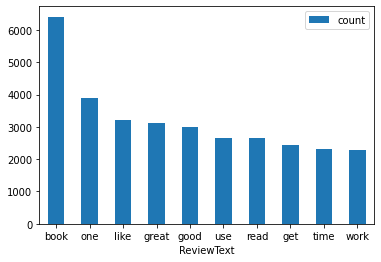

In [ ]:
# build a bar graph and plot
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches( 20, 8)
ax = df.plot.bar(x='ReviewText', y='count', rot=0)

Create a dataframe with the bag of words

In [ ]:
# build dataframe with sparse matrix X_counts
X_features_df = pd.DataFrame(X_cv.toarray())
# Rename columns with the word
X_features_df.columns = count_vect.get_feature_names()
X_features_df

,,aa,aaa,aah,aaina,aait,aaliyah,aand,aapart,aaron,aarrghh,aasinbvpeb,aaward,ab,aback,abalon,abandon,abba,abbey,abbeyorigin,abbi,abbott,abbrevi,abc,abd,abdallah,abdomen,abdomin,abduct,abduljabbar,abeautyshop,abel,abercrombi,aberdeenkenni,aberr,abid,abigail,abil,abilityth,abiogen,...,zire,zireah,zodiacmani,zoe,zohan,zohar,zoid,zojirushi,zola,zombi,zombiemrrlstin,zombiesand,zombiesi,zona,zondervan,zone,zonefre,zoo,zooland,zoom,zr,zucchini,zulu,zune,zuneha,zunesuch,zwadoo,zww,zyliss,zypan,zz,zzzzz,zzzzzzzz,zzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzz,é,été,ítem,última,único
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Adding new features , For ex. = len(review) 
X_amz_df = pd.DataFrame(X_amz_rev_part, columns = ['Review'])
X_features_df['review_len'] = X_amz_df['Review'].apply(lambda x: len(x) - x.count(" "))
X_features_df['review_len']

0        401
1        310
2        322
3        265
4        421
        ... 
11995    227
11996    161
11997    412
11998    210
11999    342
Name: review_len, Length: 12000, dtype: int64

2da parte del post

Ahora habria que aplicar el modelo de clasificacion de ML

Vamos a usar Random Forest

In [ ]:
# Evaluate the model accuracy
rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits=5)
cross_val_score(rf, X_features_df, y_amz_rev_part, cv=k_fold, scoring='accuracy', n_jobs=-1)

array([0.816, 0.81 , 0.813, 0.811, 0.8  ])

In [ ]:
# Split train and test 
X_train, X_test, y_train, y_test = train_test_split(X_features_df, y_amz_rev_part, test_size=0.2)

In [ ]:
# Class balance ??
print('Clase 0-Bad review: {} - Clase 1-Good review: {}'.format(y_train.count(0), y_train.count(1)))

Clase 0-Bad review: 2019 - Clase 1-Good review: 1981


In [ ]:
# Now, build a RandomForest with parameters, and fit the model
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)

In [ ]:
# view the 10 more important features from the model. 
# zip the Se zipea y luego se hace un sort (reverse)
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.02726511644645402, 'disappoint'),
 (0.020912705275866906, 'wast'),
 (0.01831917495554285, 'great'),
 (0.017920501401321478, 'love'),
 (0.013384825269022621, 'review_len'),
 (0.013104037294519779, 'best'),
 (0.010694394886973586, 'return'),
 (0.009690461018199323, 'excel'),
 (0.009485308138347758, 'wonder'),
 (0.007971887836040855, 'bad')]

In [ ]:
# Predict with X_test and obtain score metrics
from sklearn.metrics import precision_recall_fscore_support as score

y_pred = rf_model.predict(X_test)
precision, recall, fscore, support = score(y_test, y_pred, average='binary')

In [ ]:
print(support)

None


In [ ]:
print('Precision: {} / Recall: {} / Fscore: {} / Accuracy: {}'.format(
      round(precision,3), round(recall,3), round(fscore,3), round((y_pred==y_test).sum() / len(y_pred),3)))

Precision: 0.802 / Recall: 0.826 / Fscore: 0.814 / Accuracy: 0.809


In [ ]:
def train_RF(n_est, depth):
  
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred, average='binary')

    print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, round(precision, 3), round(recall, 3),
        round((y_pred==y_test).sum() / len(y_pred), 3)))

In [ ]:
# Build RF model with 9 combinations
# ej: 1) con 10 estimators y 10 depth, otro con 10 estim. y 20 depth, etc...
for n_est in [10, 50, 100]:
    for depth in [10, 20, 30]:
        train_RF(n_est, depth)

Est: 10 / Depth: 10 ---- Precision: 0.745 / Recall: 0.658 / Accuracy: 0.713
Est: 10 / Depth: 20 ---- Precision: 0.746 / Recall: 0.765 / Accuracy: 0.749
Est: 10 / Depth: 30 ---- Precision: 0.743 / Recall: 0.747 / Accuracy: 0.741
Est: 50 / Depth: 10 ---- Precision: 0.751 / Recall: 0.798 / Accuracy: 0.764
Est: 50 / Depth: 20 ---- Precision: 0.797 / Recall: 0.83 / Accuracy: 0.807
Est: 50 / Depth: 30 ---- Precision: 0.796 / Recall: 0.816 / Accuracy: 0.801
Est: 100 / Depth: 10 ---- Precision: 0.822 / Recall: 0.775 / Accuracy: 0.801
Est: 100 / Depth: 20 ---- Precision: 0.809 / Recall: 0.822 / Accuracy: 0.812
Est: 100 / Depth: 30 ---- Precision: 0.814 / Recall: 0.828 / Accuracy: 0.817


In [ ]:
# using GridSearch
rf = RandomForestClassifier()
param = {'n_estimators': [10, 100, 150],
        'max_depth': [10, 30, 60]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_features_df, y_amz_rev_part)
# pasamos los result de la GridSearchCV a un dataframe, y le pido que me ordene 
# por el valor 'mean_test_score'
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,23.494225,1.065035,0.188950,0.032378,60,150,"{'max_depth': 60, 'n_estimators': 150}",0.825,0.809,0.799,0.812,0.800,0.8090,0.009445,1
7,16.097585,0.095667,0.160718,0.004825,60,100,"{'max_depth': 60, 'n_estimators': 100}",0.825,0.797,0.811,0.797,0.806,0.8072,0.010400,2
5,13.959790,0.149408,0.159817,0.005580,30,150,"{'max_depth': 30, 'n_estimators': 150}",0.813,0.801,0.790,0.817,0.803,0.8048,0.009516,3
4,9.904348,0.493233,0.134703,0.003965,30,100,"{'max_depth': 30, 'n_estimators': 100}",0.808,0.795,0.794,0.802,0.783,0.7964,0.008405,4
2,4.990439,0.053000,0.117037,0.002323,10,150,"{'max_depth': 10, 'n_estimators': 150}",0.797,0.789,0.799,0.803,0.790,0.7956,0.005352,5


In [ ]:
# hasta aqui llegue 04/05/21

In [ ]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

In [ ]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

In [ ]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5),
LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

In [ ]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())
print("Features with lowest tfidf:\n{}".format(
feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(
feature_names[sorted_by_tfidf[-20:]]))

In [ ]:
# n-grams
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Stemming (nltk Porter Stemmer) and Lemmatization (Spacy)

In [ ]:
# Normalization techniques
# Stemming and lemmatization
import spacy
import nltk
# load spacy's English-language models
en_nlp = spacy.load('en')
# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()
# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [ ]:
compare_normalization(u"Our meeting today was worse than yesterday, "
"I'm scared of meeting the clients tomorrow.")

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
